# Effects of Manual Transmission on CO2 Emissions & MPG

We hear many discussions that talk about the inefficiencies of large engines. We see automakers shift from large V8 engines to smaller, more efficient and ecofriendly 4 cylinders. To prove my point, Ford added a turbo 4 cylinder option to it's Mustang line, a model historically offered with large v6 and v8 engines. This 4 cylinder Mustang is named "ecoboost". 

8 cylinders used to be the hearts of many luxury sedans, sports cars, and commercial vehicles. In today's market, luxury sedans and beefy sports cars are primarily seen with 6 cylinders (often with a turbo) and 8 cylinders are primarily seen in commercial vehicles. 4 cylinders are popular in most economical vehicle and small light sports cars. To compensate the loss of power by downgrading engine size, turbochargers are often added to squeeze more power from the smaller efficient engines.

As automakers continue to strive for greater eco-friendly cars with the development of electric cars and even more efficient gasoline-powered cars, I wondered how automakers can further cut CO2 Emissions without further sacrificing engine size or power.

With that thought in mind, I turned my direction to the transimission. How does a car's transmission affect it's CO2 emissions? Does it make a difference if the transmission was manual or automatic? If there is a discrepancy, how large is the difference? Do the number of gears affect emissions? In this article, I aim to answer these questions through the use of data and regression modeling.

Before we begin, I would like to note that I love manual cars. My first car was a manual 1992 miata and I still have it till this day (10 years later). However, I can't deny the superiority of modern automatics with their quick and responsive shifting. Throughout this analysis, my use of the word "automatic" refers to all transmissions other than manuals (smg, paddle shifters, etc.).

### Data

My idea for this research came to me when I encountered a dataset on Kaggle titled, "CO2 Emission by Vehicles". It is the dataset I use for my analysis. The link to download the dataset can be found [here](https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles). The data was collected by the Canada Government official open data website and it covers car models released/sold throughout the past 7 years. There are 7385 car models (car models released with minor changes that affects emissions are considered a unique model).


Let's get started by importing the libraries we will use in this analysis.

In [1]:
# For our general tables and data preprocessing
import pandas as pd
import re
import numpy as np

# For our regression model
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse

# For bootstrapping
from random import choice

# For our plots and graphs
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# For clean tables
from stargazer.stargazer import Stargazer

Let's load in the data into a pandas dataframe and observe the first few lines to see what we are working with.

In [2]:
df = pd.read_csv('CO2 Emissions_Canada.csv')
df.head(5)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


Our primary variable of interest is whether a car is manual or automatic. Our dataset provides us this information in a string type variable called "transmission". The values of this feature starts with "M" if the car is manual and "A" if the car is automatic. The number at the end of the string represents the number of gears the transmission has. We will create a binary variable called "man", where values will be 1 if the transmission is manual and 0 if the transmission is automatic.

I believe that the number of gears may prove to be useful for our analysis; therefore, we will create a function using regex to extract and create a new feature called "gears".

In [3]:
# First drop rows we do not want.
cols_to_drop = ['Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)']
df.drop(columns = cols_to_drop, inplace = True)

# Create a function to extract gears using apply lambda.
def get_gear(trans):
    gears = (re.findall(r'[0-9]+', trans))
    if len(gears) == 0:
        return np.nan
    else:
        return int(re.findall(r'[0-9]+', trans)[0])

# Create Binary Variable for transmissions
df['man'] = df.Transmission.apply(lambda x: 1 if x.startswith('M') else 0)

# Create Gears variable
df['gears'] = df.Transmission.apply(lambda x: get_gear(x))
df.dropna(inplace = True)

Our goal is to measure the effects of manual on CO2. Our data is not a collection of vehicles that were randomly recorded but rather a collection of all combination of cars and transimission options offered in the market. Because of the structure of our data, we can not measure CO2 differences as if we were running randomized trials. However, we will measure the effects of manual transmissions on CO2 output in a similar fashion, namely we will borrow an analysis technique called multiple linear regression, a technique popular for measuring treatment effects of randomized experiments.

For this analysis, we will consider manual transmission as a treatment variable. This means that all cars that are labeled manual will belong to the treatment group and all automatic cars will belong to the control group. However, we can not simply put all cars with automatic transimissions into the control group because most cars are offered in only one transmission type and there are many unobserved variables that have effects on CO2 (weight, power, aspiration, fuel type, etc). To accurately measure the effects of manual on CO2, we need _ceteris paribus_, or all other things equal. This means that for every car in the treatment group, we would need a car that is similar (or as closely similar as possible) to the treatment car, with the exception of the treatment variable (transmission type). To simplify this process, we will only keep vehicles that are offered in both, manual and automatic. Doing so will guarantee that our vehicles in both groups are identical with the exception of the transimission type. This also effectively eliminates any selection bias. 

Here are where our data cleaning techiniques get some-what funky. (Please read commented lines to follow the process)

In [4]:
# Drop duplicates. We keep one copy of each vehicle-tranmission combination. Some cars have multiple entries representing
# a different year release of a specific model. A specific model may have differences in CO2 output across the different 
# years. We keep the last because the most recent year of a vehicle will provide the most relevant CO2 performance.
df= df.drop_duplicates(subset=['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'man'], keep= 'last')

In [5]:
# Create a bool mask that labels cars with duplicates True. Note that we exclude 'man' when identifying duplicates.
# By excluding 'man' we can obtain all cars that are offered in both manual and automatic transmission.
dupes = df.duplicated(subset=['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Fuel Type', 'Cylinders'], keep = False)

In [6]:
# Apply the boolean mask to the dataframe.
df = df[dupes == True]

In [7]:
# See how we have the same number of manual and automatic cars now?
df.groupby('man').agg({'man':'count'}).rename(columns = {'man':'count'})

,count
man,
0,454
1,454


And with that, our data aggregation step is complete. We have 454 cars that are offered in both transmission type. The vehicle models in the control group are exactly the same as the treatment group; therefore, the control variables should be identical.

Let's see if we can identify a copy of a vehicle for each class (man = 1 and man = 0).

In [8]:
assert len(df[(df.Model == '86') & (df.man == 1)]) == 1
assert len(df[(df.Model == '86') & (df.man == 0)]) == 1
df[(df.Model == '86')]

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption Comb (mpg),CO2 Emissions(g/km),man,gears
7313,TOYOTA,86,MINICOMPACT,2.0,4,AS6,Z,32,204,0,6.0
7314,TOYOTA,86,MINICOMPACT,2.0,4,M6,Z,29,232,1,6.0


Perfect. We have two entries for Toyota 86. One automatic and one manual transmission. Vehicle class, engine size, cylinders, and fuel type are identical as they should be. After all, they are the same car model.

Lastly, we will tidy up the DataFrame a little by shortening some column names. We will also create two new columns: the natural log of CO2 emissions and the natural log of Engine size.

In [9]:
df = df.rename(columns ={'CO2 Emissions(g/km)': 'CO2_Emi', 'Engine Size(L)':'Engine_Size', 'Fuel Consumption Comb (mpg)':'mpg'})
df['ln_CO2_Emi'] = [np.log(x) for x in df.CO2_Emi]
df['ln_Engine_Size'] = [np.log(x) for x in df.Engine_Size]
df['ln_mpg'] = [np.log(x) for x in df.mpg]

df.head(6)

,Make,Model,Vehicle Class,Engine_Size,Cylinders,Transmission,Fuel Type,mpg,CO2_Emi,man,gears,ln_CO2_Emi,ln_Engine_Size,ln_mpg
7,ACURA,TL AWD,MID-SIZE,3.7,6,AS6,Z,25,255,0,6.0,5.541264,1.308333,3.218876
8,ACURA,TL AWD,MID-SIZE,3.7,6,M6,Z,24,267,1,6.0,5.587249,1.308333,3.178054
9,ACURA,TSX,COMPACT,2.4,4,AS5,Z,31,212,0,5.0,5.356586,0.875469,3.433987
10,ACURA,TSX,COMPACT,2.4,4,M6,Z,29,225,1,6.0,5.416100,0.875469,3.367296
81,BMW,328i,COMPACT,2.0,4,A8,Z,34,193,0,8.0,5.262690,0.693147,3.526361
82,BMW,328i,COMPACT,2.0,4,M6,Z,32,200,1,6.0,5.298317,0.693147,3.465736


### Exploration Analysis

Let's first see the distribution of our independent variables (CO2 & mpg). 

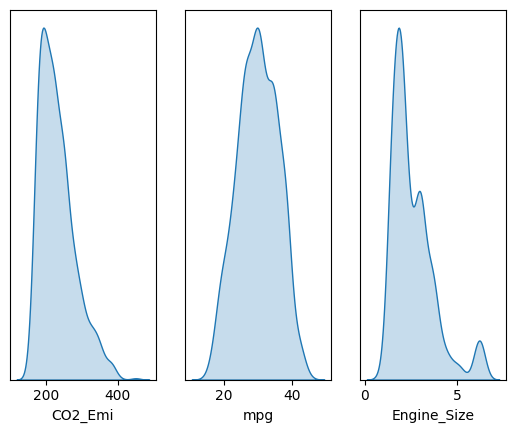

In [10]:
fig, axes = plt.subplots(1,3, sharey = False)
sns.kdeplot(df.CO2_Emi, fill=True, ax = axes[0])
sns.kdeplot(df.mpg, fill=True, ax = axes[1])
sns.kdeplot(df.Engine_Size, fill=True, ax = axes[2])
axes[0].get_yaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
plt.show()

The distribution of CO2 emissions clearly does not look normal. It appears to be skewed to the right. Engine size doesn't look any better, as it appears to have a multimodal distribution. Lastly, mpg is the only variable that appears to looks relatively normal.

Although normality is only important for the distribution of our residuals, it is nice to see the distribution of our variables to get a better understanding of our data.

You may remember that I created a few new columns: ln_CO2_Emi, ln_mpg, and ln_Engine_Size. Taking the natural log of a variable, essentially squashes the distribution of our variables, in the hopes that our skewedly distributed variables become some-what normal. 

Let's see the distributions of our variables after being log transformed.

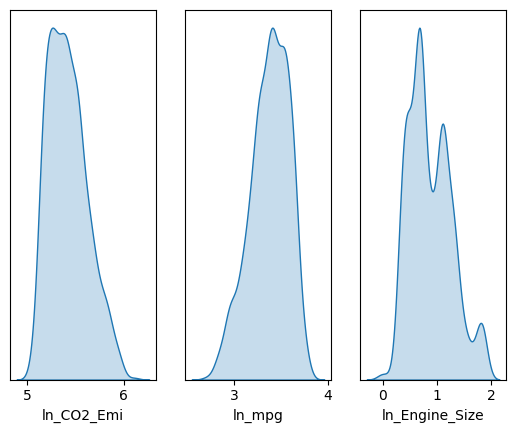

In [11]:
fig, axes = plt.subplots(1,3, sharey = False)
sns.kdeplot(df.ln_CO2_Emi, fill=True, ax = axes[0])
sns.kdeplot(df.ln_mpg, fill=True, ax = axes[1])
sns.kdeplot(df.ln_Engine_Size, fill=True, ax = axes[2])
axes[0].get_yaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
plt.show()

The distribution of ln_CO2_Emi looks better in regards to a normal distribution. On the other hand, taking the log of mpg, turned what originally looked normal, into a distribution that is slightly skewed to the left. Lastly, the distribution of ln_Engine_Size still looks multimodal.

As I previously mentioned, the distribution of our dependent and independent variables is not important to our linear regression models. Only the distribution of our error terms (residuals) are relevant when determining significance as it used to compute standard deviation and p-values.

Next, let's see the number of car models that increase or decrease when equipped with a manual transmission.

In [12]:
# Create a unique id for our car models and create a list of all unique car models.
df['full_model'] = df.Make + '_' + df.Model + '_' + df['Vehicle Class'] + '_' + df['Engine_Size'].astype(str)
car_list = df['full_model'].unique()

# Saniy Check to ensure there are 454 unique car models.
assert len(car_list) == 454

# we will create lists of differences in co2 and mpg by subtracting a manual model with it's automatic counterpart.
diff_in_co2 = []
diff_in_mpg = []

for car in car_list:
    
    auto_co2 = df[(df.full_model == car) & (df.man == 0)]['CO2_Emi'].item()
    man_co2 = df[(df.full_model == car) & (df.man == 1)]['CO2_Emi'].item()
    diff_in_co2.append((man_co2-auto_co2))
    
    auto_mpg = df[(df.full_model == car) & (df.man == 0)]['mpg'].item()
    man_mpg = df[(df.full_model == car) & (df.man == 1)]['mpg'].item()
    diff_in_mpg.append((man_mpg-auto_mpg))

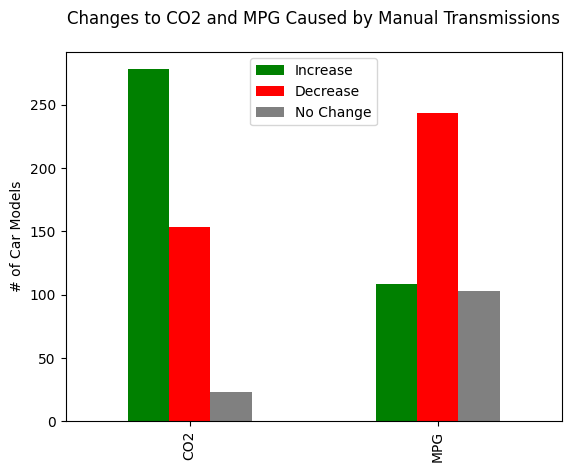

In [13]:
co2_inc = list(filter(lambda co2_output: co2_output > 0, diff_in_co2))
co2_dec = list(filter(lambda co2_output: co2_output < 0, diff_in_co2))
co2_nochange = list(filter(lambda co2_output: co2_output == 0, diff_in_co2))

mpg_inc = list(filter(lambda mpg_output: mpg_output > 0, diff_in_mpg))
mpg_dec = list(filter(lambda mpg_output: mpg_output < 0, diff_in_mpg))
mpg_nochange = list(filter(lambda mpg_output: mpg_output == 0, diff_in_mpg))

change_df = pd.DataFrame(
    {'Dependent': ['CO2', 'MPG'], 
     'Increase': [len(co2_inc), len(mpg_inc)], 
     'Decrease': [len(co2_dec), len(mpg_dec)],
     'No Change': [len(co2_nochange), len(mpg_nochange)]
    })

change_df.plot(x = 'Dependent', y = ['Increase', 'Decrease', 'No Change'], kind= 'bar', color = ['green', 'red','gray'])
plt.ylabel('# of Car Models')
plt.xlabel(None)
plt.title('Changes to CO2 and MPG Caused by Manual Transmissions', pad= 20)
plt.show()

In [14]:
change_df

,Dependent,Increase,Decrease,No Change
0,CO2,278,153,23
1,MPG,108,243,103


Out of the 454 car models, 278 cars saw an increase in CO2 Emissions, 153 cars saw a decrease, and 23 cars saw no change in CO2 Emissions.

Out of the 454 car models, 108 cars saw an increase in combined fuel consumption (mpg), 243 cars saw a decrease, and 103 cars saw no change in fuel consumption.

I don't think we need to be rocket scientists to know that CO2, like all greenhouse gases, are bad for our environment. In addition, I think it is common knowledge that fuel efficient cars tend to be more eco-friendly and emit less CO2. To simply put it, CO2 emissions and fuel consumption should have a strong negative correlation. Cars that are more fuel efficient (higher mpg) emit less CO2 (less CO2 Emissions) and vice versa. 

That being said, the results of our frequency counts for changes to CO2 and mpg agree with each other. That is, most cars saw an increase in CO2 emissions and decrease in mpg when equipped with a manual transmission.

Let's see the average CO2 emission and mpg for both our transmission groups.

In [15]:
df.groupby('man').agg({'mpg':['mean','min','max'], 'CO2_Emi':['mean','min','max']})

mpg             CO2_Emi          
          mean min max        mean  min  max
man                                         
0    30.301762  17  43  226.812775  155  388
1    29.442731  15  45  233.530837  158  450

We can see that the average CO2 emissions for manual cars is about 6.7 higher than automatics. Our manual group also have a higher minimum and maximum CO2 emissions than automatics. This suggests that cars do emit more CO2 when equipped with a manual transmission. 

Additionally, mpg for manual cars perform worse than automatics with a 0.85 lower average. In addition, minimum mpg for manual cars is lower than automatics. Interestingly, the maximum mpg for manual cars is higher than automatics, suggesting that manual cars can achieve greater fuel efficiency than automatics.

Now that we do know there is a difference in CO2 Emissions and fuel efficiency between the two transmission types, we will model the effects in a linear regression model.

### Split DataFrame to Train and Test DataFrames

Here, we split car_list because we want to split at the unit level (by car models).

In [16]:
RANDOM_SEED = 42
train_car_list, test_car_list = train_test_split(car_list, random_state = RANDOM_SEED)

train_df = df[df.full_model.isin(train_car_list)]
test_df = df[df.full_model.isin(test_car_list)]

### Multiple Linear Regression

To perform multiple linear regression analysis, we must first see whether some assumptions are met. 

    1) Our independent variables should have linear relationships with the dependent variable.
    2) Our independent variables should not be strongly correlated with each other.
    3) Residuals should be normally distributed.
    4) Homoscedasticity. 
    
We can check for the first two assumptions by computing a correlation matrix.

In [17]:
train_df[['Engine_Size', 'Cylinders', 'gears', 'man', 'CO2_Emi']].corr().round(2)

,Engine_Size,Cylinders,gears,man,CO2_Emi
Engine_Size,1.00,0.92,0.31,0.00,0.88
Cylinders,0.92,1.00,0.31,0.00,0.86
gears,0.31,0.31,1.00,-0.47,0.20
man,0.00,0.00,-0.47,1.00,0.08
CO2_Emi,0.88,0.86,0.20,0.08,1.00


Engine size and Cylinders have strong correlation with CO2 emissions; however they also have very strong correlation with each other (0.92). This is no surprise since larger engines tend to have more cylinder and displacement. Because of their strong multicollinearity, we will exclude one of these variables from our regression models. Engine size is a discrete variable and cylinder is a ordinal variable. Because the range of possible values are larger for Engine size than Cylinders, we will use Engine Size for greater precision.

Gears and man do not have strong correlation with CO2. This will not be an issue for man since man is a dummy variable that only takes values 1 or 0. We will exclude gears in our regression analysis for CO2.

In [18]:
# Cluster by unit level (car model)
ln_co2_result = smf.ols(
    formula="np.log(CO2_Emi) ~ np.log(Engine_Size) + man", data=train_df
).fit(cov_type = 'cluster', cov_kwds = {'groups':train_df.full_model})

ln_co2_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(CO2_Emi)   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     606.9
Date:                Sun, 16 Jul 2023   Prob (F-statistic):          9.37e-113
Time:                        00:55:38   Log-Likelihood:                 692.20
No. Observations:                 680   AIC:                            -1378.
Df Residuals:                     677   BIC:                            -1365.
Df Model:                           2                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.0104      0.012    430.834      0.000       4.988       5.033
np.log(Engine_Size)     0.4469      0.013     33.839      0.000       0.421       0.473
man                     0.0309      0.004      8.018      0.000       0.023       0.038
==============================================================================
Omnibus:                        0.686   Durbin-Watson:                   1.314
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.605
Skew:                           0.071   Prob(JB):                        0.739
Kurtosis:                       3.035   Cond. No.                         5.20
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

Before we interperet any results, let's test for normality. We can visually check this assumption by plotting residuals in a QQ plot or a density plot.

C:\Users\kenny\AppData\Local\Temp\ipykernel_4072\1943741167.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  resid_plt.show()


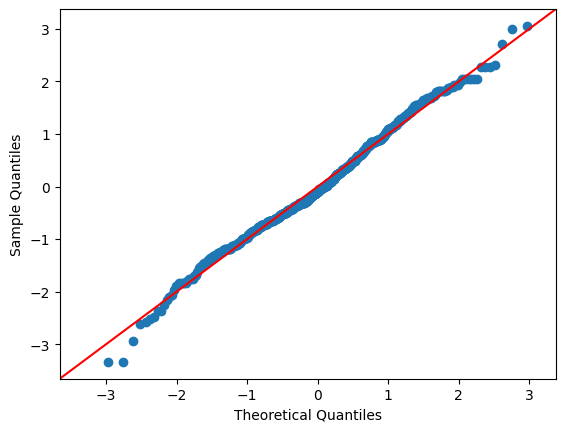

In [19]:
ln_co2_resid = ln_co2_result.resid
resid_plt = sm.qqplot(ln_co2_resid, fit= True, line= '45')
resid_plt.show()

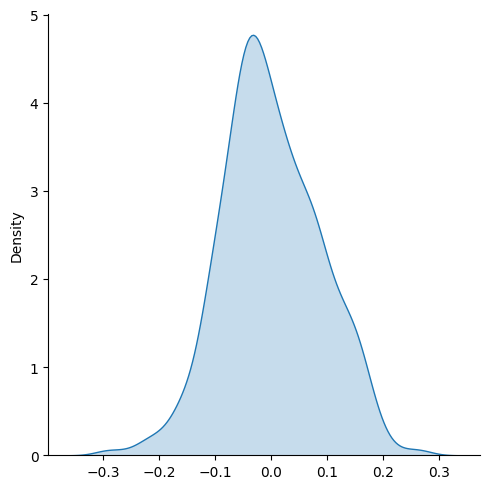

In [20]:
sns.displot(ln_co2_resid, kind = 'kde', fill=True)
plt.show()

By plotting the residuals in a QQ plot, we can see a relatively straight line. By plotting the residuals in a density plot, we get a distribution that appears to be slighly skewed but normal enough.

We can then verify the homoskedasticity assumption by plotting residuals against predicted CO2.

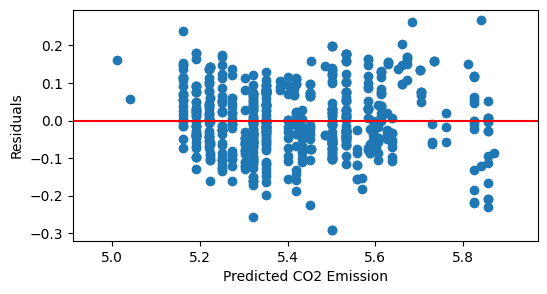

In [21]:
predicted_co2 = ln_co2_result.predict()
plt.figure(figsize= (6,3))
plt.plot([0]*len(predicted_co2), c = 'red')
plt.scatter(x = predicted_co2, y = ln_co2_resid)
plt.xlim(predicted_co2.min() - .1, predicted_co2.max() + .1)
plt.xlabel('Predicted CO2 Emission')
plt.ylabel('Residuals')
plt.show()

We know our residuals are heteroskedastic if the residuals appear to be increasing or decreasing as our predicted CO2 emissions increases. In other words, if the points from the graph above form a cone shape, the homoskedasticity assumption would be violated. 

By observing the graph above, our data appears to have no signs of heteroskedaticity; therefore the homoskedasticity assumption checks out.

Going back to our regression results:

In [22]:
ln_co2_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(CO2_Emi)   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     606.9
Date:                Sun, 16 Jul 2023   Prob (F-statistic):          9.37e-113
Time:                        00:55:40   Log-Likelihood:                 692.20
No. Observations:                 680   AIC:                            -1378.
Df Residuals:                     677   BIC:                            -1365.
Df Model:                           2                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.0104      0.012    430.834      0.000       4.988       5.033
np.log(Engine_Size)     0.4469      0.013     33.839      0.000       0.421       0.473
man                     0.0309      0.004      8.018      0.000       0.023       0.038
==============================================================================
Omnibus:                        0.686   Durbin-Watson:                   1.314
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.605
Skew:                           0.071   Prob(JB):                        0.739
Kurtosis:                       3.035   Cond. No.                         5.20
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

A car that is equipped with a manual transmission increases CO2 emissions by about 3.1%. If a car equipped with an automatic transimission outputs 300 g/km CO2, a manual transmission variant would output about 9.3 g/km more CO2. In addition, a 1% increase to engine size would increase CO2 emissions by about 0.45%

Our coefficients are statistically significant at the 0.01 level.

Let's see how manual transmission affects Fuel efficiency.

### Effects of Manual on Gas Mileage

In [23]:
ln_mpg_result = smf.ols(
    formula="np.log(mpg) ~ np.log(Engine_Size) + man", data=train_df
).fit(cov_type = 'cluster', cov_kwds = {'groups':train_df.full_model})
ln_mpg_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     591.4
Date:                Sun, 16 Jul 2023   Prob (F-statistic):          2.89e-111
Time:                        00:55:40   Log-Likelihood:                 646.60
No. Observations:                 680   AIC:                            -1287.
Df Residuals:                     677   BIC:                            -1274.
Df Model:                           2                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.7886      0.012    307.378      0.000       3.764       3.813
np.log(Engine_Size)    -0.4508      0.014    -33.299      0.000      -0.477      -0.424
man                    -0.0328      0.004     -8.068      0.000      -0.041      -0.025
==============================================================================
Omnibus:                        3.724   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.664
Skew:                           0.129   Prob(JB):                        0.160
Kurtosis:                       3.251   Cond. No.                         5.20
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

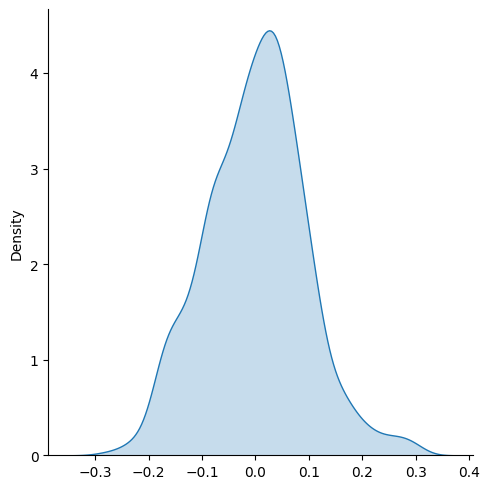

In [24]:
ln_mpg_resid = ln_mpg_result.resid
sns.displot(ln_mpg_resid, kind = 'kde', fill=True)
plt.show()

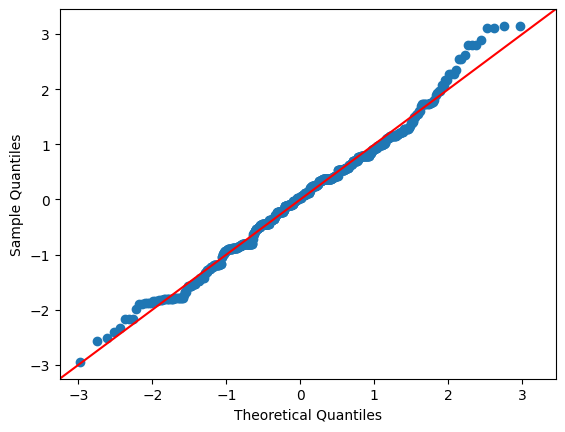

In [25]:
sm.qqplot(ln_mpg_resid, fit= True, line= '45')
plt.show()

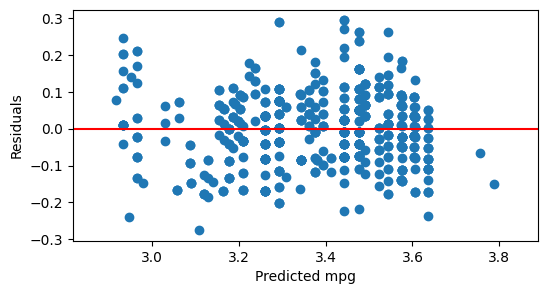

In [26]:
predicted_mpg = ln_mpg_result.predict()
plt.figure(figsize= (6,3))
plt.plot([0]*len(predicted_mpg), c = 'red')
plt.scatter(x = predicted_mpg, y = ln_mpg_resid)
plt.xlim(predicted_mpg.min() - .1, predicted_mpg.max() + .1)
plt.xlabel('Predicted mpg')
plt.ylabel('Residuals')
plt.show()

Going back to our results:

In [27]:
ln_mpg_result = smf.ols(formula="np.log(mpg) ~ np.log(Engine_Size) + man", data=df).fit()
ln_mpg_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1526.
Date:                Sun, 16 Jul 2023   Prob (F-statistic):          1.24e-290
Time:                        00:55:41   Log-Likelihood:                 817.07
No. Observations:                 908   AIC:                            -1628.
Df Residuals:                     905   BIC:                            -1614.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.7931      0.009    439.253      0.000       3.776       3.810
np.log(Engine_Size)    -0.4608      0.008    -55.047      0.000      -0.477      -0.444
man                    -0.0304      0.007     -4.642      0.000      -0.043      -0.018
==============================================================================
Omnibus:                        7.106   Durbin-Watson:                   1.200
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                8.133
Skew:                           0.126   Prob(JB):                       0.0171
Kurtosis:                       3.389   Cond. No.                         5.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A car that is equipped with manual has about 3% less mpg than the same car with an automatic transmission. In addition, for every 1% increase to engine size, mpg decreases by about 46%. 

The coefficients of our model are statistically significant at the 0.01 level.

### Bootstrapping

The last techinique I would like to try is called bootstrapping. Bootstrapping draws a subsample from our data pool and records the result as an entry to a new set of data. In our case, we will randomly draw 30 cars (by unit level) from 454 cars and record the average CO2 emission, mpg, and engine size for the automatic and manual transimission variant. 

This will effectively create data that has an approximate normal distribution and a lower variance.

We will then use our new bootstrapped data to build new regression models.

In [28]:
# We will create a dictionary to record the neccessary variables of our bootstrap model.
bootstrap_results = {'engine_size':[],'co2':[],'mpg':[], 'man':[], 'cluster':[]}

for c in range(400):
    sample_car_list = []
    for __ in range(40):
        car = choice(car_list)
        sample_car_list.append(car)
    boot_df = train_df[train_df.full_model.isin(sample_car_list)].groupby('man').agg({'CO2_Emi':'mean', 'mpg':'mean', 'Engine_Size':'mean'}).reset_index()
    boot_df['cluster'] = c
    for t in boot_df.iterrows():
        bootstrap_results['man'].append(t[1].man)
        bootstrap_results['co2'].append(t[1].CO2_Emi)
        bootstrap_results['mpg'].append(t[1].mpg)
        bootstrap_results['engine_size'].append(t[1].Engine_Size)
        bootstrap_results['cluster'].append(t[1].cluster)

# Create a DataFrame with the dictionary
bootstrap_df = pd.DataFrame(bootstrap_results)

# See how our bootstrapped data looks
bootstrap_df.head(6)

,engine_size,co2,mpg,man,cluster
0,2.525000,221.187500,30.781250,0.0,0.0
1,2.525000,230.156250,29.656250,1.0,0.0
2,2.980000,235.466667,29.033333,0.0,1.0
3,2.980000,243.866667,28.200000,1.0,1.0
4,3.061538,244.307692,28.384615,0.0,2.0
5,3.061538,253.307692,27.115385,1.0,2.0


Our new data has been created. Let's see if the distribution of our new data is normal.

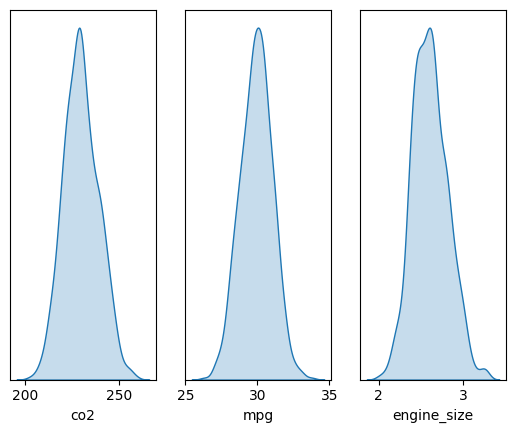

In [29]:
fig, axes = plt.subplots(1,3, sharey = False)
sns.kdeplot(bootstrap_df.co2, fill=True, ax = axes[0])
sns.kdeplot(bootstrap_df.mpg, fill=True, ax = axes[1])
sns.kdeplot(bootstrap_df.engine_size, fill=True, ax = axes[2])
axes[0].get_yaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
plt.show()

If you remember the distribution results from our exploratory analysis, co2 was slightly skewed to the right, engine size had a multimodal distribution and mpg had a distribution that was approxiately normal. Even after we performed log transformations, the distributions remained questionable. Log transformations squashed the distribution in an attempt to alleviate the severness of the skewness but it did not necessarily get rid of the skew. 

However, bootstrapping draws sample averages from our data pool which ultimately creates data that is approximately normal, has a mean that resembles our sample mean, and has a standard deviation that is smaller than that of our sample data's. The plot above shows that our bootstrapping technique has created data that looks unquestionably normal.

Let's plot the distribution of our manual and automatic cars in two seperate distributions.

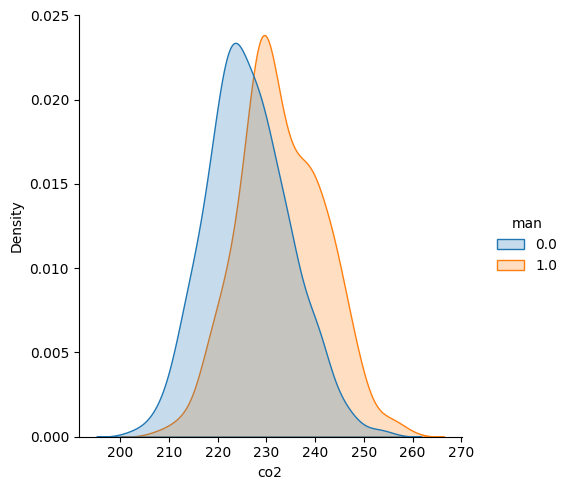

In [30]:
sns.displot(data = bootstrap_df, x='co2', hue = 'man', kind = 'kde', fill=True)
plt.show()

We can see that the distribution for both transmission type are normal and that manual cars have higher CO2 emissions than that of automatic's. Keep in mind that the cars drawn for both groups are the exact same with the exception of transmission type; therefore, all control variables (observed and unobserved) are the exact same.

Moving on, we will create our new regression model for CO2 emissions.

In [31]:
co2_boot_result = smf.ols(
    formula="co2 ~ engine_size + man", data=bootstrap_df
).fit(cov_type = 'cluster', cov_kwds = {'groups':bootstrap_df.cluster})

co2_boot_resid = co2_boot_result.resid
co2_boot_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     2046.
Date:                Sun, 16 Jul 2023   Prob (F-statistic):          1.86e-210
Time:                        00:55:44   Log-Likelihood:                -2249.1
No. Observations:                 800   AIC:                             4504.
Df Residuals:                     797   BIC:                             4518.
Df Model:                           2                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     131.0679      2.111     62.089      0.000     126.930     135.205
engine_size    36.5504      0.811     45.060      0.000      34.961      38.140
man             6.7541      0.149     45.246      0.000       6.461       7.047
==============================================================================
Omnibus:                        1.320   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                1.396
Skew:                           0.091   Prob(JB):                        0.498
Kurtosis:                       2.908   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

A car model equipped with a manual transmission would have about 7 g/km increased CO2 emissions compared to the same car model with a automatic transmission. In addition, a 1 liter increase to engine size would increase CO2 emissions by about 36 g/km. The coefficients of our model are statistically significant at the 0.01 level. 

Next, we will check if our normality and homoskedasticity assumptions still hold.

C:\Users\kenny\AppData\Local\Temp\ipykernel_4072\103344796.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  resid_plt.show()


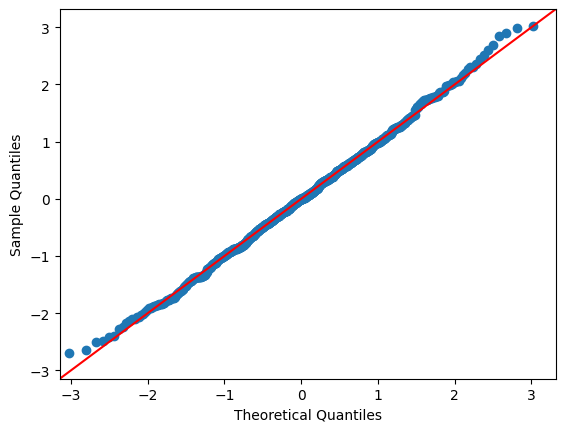

In [32]:
resid_plt = sm.qqplot(co2_boot_resid, fit= True, line= '45')
resid_plt.show()

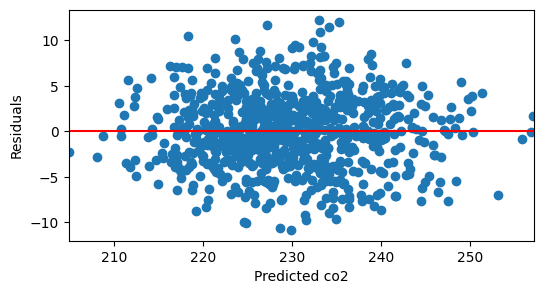

In [33]:
predicted_co2 = co2_boot_result.predict()
plt.figure(figsize= (6,3))
plt.plot([0]*len(predicted_co2), c = 'red')
plt.scatter(x = predicted_co2, y = co2_boot_resid)
plt.xlim(predicted_co2.min() - .1, predicted_co2.max() + .1)
plt.xlabel('Predicted co2')
plt.ylabel('Residuals')
plt.show()

As demonstrated in our qq plot and residuals vs predicted scatter plot, we can see that both our assumptions are valid.

Moving on to our bootstrapped mpg regression model:

In [34]:
mpg_boot_result = smf.ols(
    formula="mpg ~ engine_size + man", data=bootstrap_df
).fit(cov_type = 'cluster', cov_kwds = {'groups':bootstrap_df.cluster})

mpg_boot_resid = mpg_boot_result.resid
mpg_boot_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1315.
Date:                Sun, 16 Jul 2023   Prob (F-statistic):          2.49e-176
Time:                        00:55:45   Log-Likelihood:                -713.16
No. Observations:                 800   AIC:                             1432.
Df Residuals:                     797   BIC:                             1446.
Df Model:                           2                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      40.7732      0.356    114.446      0.000      40.075      41.471
engine_size    -4.0055      0.136    -29.479      0.000      -4.272      -3.739
man            -0.8692      0.020    -43.120      0.000      -0.909      -0.830
==============================================================================
Omnibus:                        0.591   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.744   Jarque-Bera (JB):                0.583
Skew:                          -0.066   Prob(JB):                        0.747
Kurtosis:                       2.988   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

A car model equipped with a manual transmission would have about 1 less mpg compared to the same car model with a automatic transmission. In addition, a 1 liter increase to engine size would decrease fuel efficiency by about 4 mpg. The coefficients of our model are statistically significant at the 0.01 level.

Let's see if homoskedasticity and normality assumptions hold for our error terms.

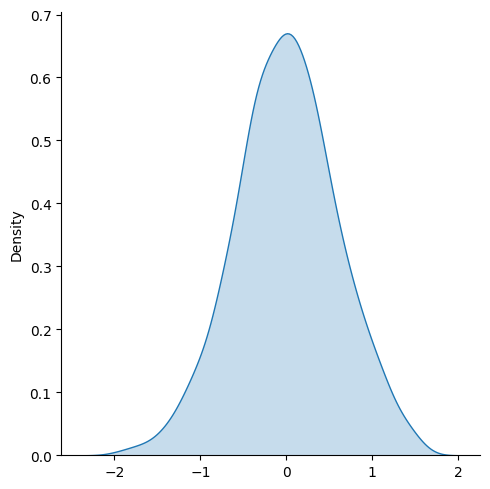

In [35]:
sns.displot(mpg_boot_resid, kind = 'kde', fill=True)
plt.show()

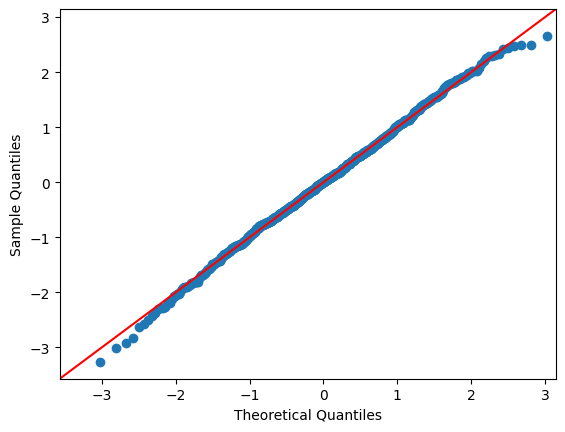

In [36]:
sm.qqplot(mpg_boot_resid, fit= True, line= '45')
plt.show()

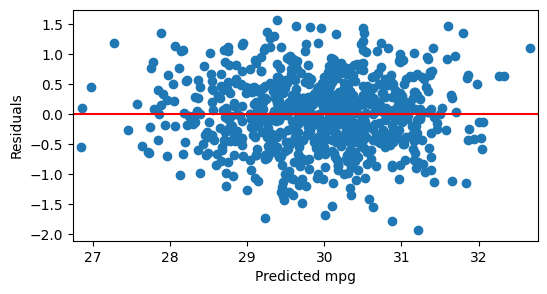

In [37]:
predicted_mpg = mpg_boot_result.predict()
plt.figure(figsize= (6,3))
plt.plot([0]*len(predicted_mpg), c = 'red')
plt.scatter(x = predicted_mpg, y = mpg_boot_resid)
plt.xlim(predicted_mpg.min() - .1, predicted_mpg.max() + .1)
plt.xlabel('Predicted mpg')
plt.ylabel('Residuals')
plt.show()

Similarly to our co2 model, the assumptions for our mpg model are valid.

### Model Evaluation

Here, we use our test_df to evaluate our regression models. We will use mean squared error (MSE) as our evaulation metric. Our log transformed model will have an mse score that is computed using logged values. To undo the log transformation, we will use numpy's exp function to undo the log transformion of our predicted logged values. 

In [38]:
co2_actual = test_df['CO2_Emi']
co2_boot_pred = co2_boot_result.predict(exog= dict(engine_size = test_df['Engine_Size'].to_numpy(), man = test_df['man'].to_numpy()))
ln_co2_pred = ln_co2_result.predict(exog= dict(Engine_Size = test_df['Engine_Size'].to_numpy(), man = test_df['man'].to_numpy()))

In [39]:
mse(co2_actual, co2_boot_pred)

721.0494771019679

In [40]:
mse(co2_actual, np.exp(ln_co2_pred))

662.4636075965246

We used mean square error to determine which model performs better. Based on our results, our bootstrap model for CO2 emissions has mse of 726 and our log transformed model has mse of 662; therefore, our log transformed model is the better performing model.

In [41]:
mpg_actual = test_df['mpg']
mpg_boot_pred = mpg_boot_result.predict(exog= dict(engine_size = test_df['Engine_Size'].to_numpy(), man = test_df['man'].to_numpy()))
ln_mpg_pred = ln_mpg_result.predict(exog= dict(Engine_Size = test_df['Engine_Size'].to_numpy(), man = test_df['man'].to_numpy()))

In [42]:
mse(mpg_actual, mpg_boot_pred)

14.53923641817133

In [43]:
mse(mpg_actual, np.exp(ln_mpg_pred))

11.388652471253629

Based on our results, our bootstrap model for mpg has mse of 15 and our log transformed model has mse of 11. The log transformed model for co2 appears to perform better than our bootstrap co2 model.

### Conclusion

In [44]:
summary_table = Stargazer([ln_co2_result, co2_boot_result, ln_mpg_result, mpg_boot_result])
summary_table.custom_columns(['ln(co2)', 'bootstrap co2', 'ln(mpg)', 'bootstrap mpg'], [1,1,1,1])
summary_table.show_model_numbers(False)
summary_table.title("Final Results")
summary_table.covariate_order(['Intercept', 'engine_size', 'np.log(Engine_Size)', 'man'])
summary_table

To recap our journey, we filtered our original dataset to include only car models that were offered in both, manual and automatic transmission. Doing so, gave us a pair of entries for every car model where features between the pair were identical with the exception of transmission. Our working dataset had 908 cars: 454 manual cars and 454 automatic cars. We considered manual a treatment and car models as a unit level.

In our exploratory analysis, we painted a clear difference in CO2 Emission and Fuel Efficiency between our manual transmission group (treatment) and automatic group (control). 61% of the 454 car models had higher CO2 emissions when equipped with a manual transmission, 34% of the 454 car models had lower CO2 emissions, and 5% of cars saw no change. As for fuel efficiency, 24% of the 454 car models had higher mpg when equipped with a manual transmission, 54% of the 454 car models had lower mpg, and 22% of the 454 car models saw no change in mpg. 

We then created regression models to measure two dependent variables: CO2 and mpg. For each dependent variable, we created a OLS model where we applied log transformations to engine size and to the depedent variables itself (CO2 Emissions & mpg). In addition to log transformed models, we created OLS models by using a boothstrapping technique. Our bootstrap technique consists of randomly drawing 40 car models to create two subsamples with identical features other than transmission type, record sample averages, and repeating the process for 400 iterations.

The results of our regression models showed that the log transformation technique performed better than our bootstrap technique in metrics of MSE (Mean Squared Errors) when modeling both, CO2 emissions and mpg.

Our log transformed model suggests a 3.1% increase in CO2 emissions when cars are equipped with a manual transmission. To put this in perspective, an automatic car emitting the average 227 g/km CO2 would see an additional 7 g/km CO2 if it were equipped with a manual transmission instead. Similarly, our bootstrap model suggests a 7 g/km increase to CO2 emissions when equipped with a manual transmission. Both results align closely to the average difference of 6.7 g/km.

Turning our heads to fuel efficiency, our log transformed model, suggests a 3% decrease in fuel efficiency when equipped with a manual transmission. Our bootstrap model suggests a 0.85 mpg decrease when equipped with a manual transmission. Both results align closely to the average difference of -0.93.

The results of our regession are significant at all levels. However, the magnitude of the size differences are low, especially for fuel efficiency where differences are less than 1. 1 less mpg makes little to no difference to the average Joe. Most people wouldn't consider the small difference notable. Similarly, manual cars only see about a 7 g/km increase to CO2 emissions. The size magnitude does not seem detrimental to our environment nor will it affect a driver directly in anyway. However, when we take into account, the number of manual cars that are on the road and the number of miles we put on the odometer, the aggregated amount of CO2 emitted adds up, which can aggregate to a concerning amount.

I am no enviromentalist. I recycle and pickup small trash (so my tortoise doesn't eat it) but I know nothing about greenhouse gases or the levels of CO2 output that is considered hazardous to our ecosystem. I actually prefer manual transimissions and believe everyone should experience the joy of driving one. The purpose of this analysis is to explore differences in CO2 output and fuel efficiency between automatics and manuals, not to convince you readers to avoid cars with manual transmissions. 

That being said, thank you for reading my article. I enjoy writing narratives and doing analysis but it has been quite some time since I dabbled in statistics. If I made an errors in my methods, please comment to let me know. In addition, if you have any feedback on improvements, I would love to hear them as well.